<a href="https://colab.research.google.com/github/andrejadikic/IgraZivotaPython/blob/main/Projekat1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Prvi zadatak

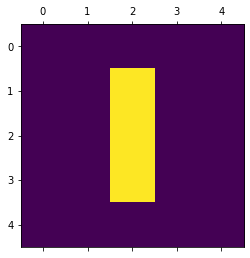

In [3]:
import threading
import random
import numpy as np
from matplotlib.animation import FuncAnimation
import matplotlib.pyplot as plt
from IPython.display import HTML

values = [0,1]
n = 5
#state je trenutno stanje matrice
#state = np.random.choice(values, n*n).reshape(n,n)
state = np.zeros((n, n)).astype(np.int8)
state[1][2]=1;
state[2][2]=1;
state[3][2]=1;
steps = [state]


#steps je matrica stanja koja pamti promenu stanja od iteracije do iteracije
#steps = [(np.random.rand(n**2).reshape(n, n) > 0.5).astype(np.int8)for i in range(n)]

#readcounters je brojac suseda koji su procitali trenutnu vrednost kad dodje do 8 onda se menja vrednost celije
readcounters = np.zeros((n, n)).astype(np.int8)
#cell_lock_counter za state da se menja 
cell_lock_counter = np.array([threading.Lock() for i in range(n*n)]).reshape(n,n)
# matrica key za readcounter
read_key = np.array([threading.Lock() for i in range(n*n)]).reshape(n,n)
# iter_lock je lock za sledecu iteraciju
iter_lock = threading.Lock()
# iter_counter broji koliko celija je uslo u cekaonicu
iter_counter = 0
# finish_counter koliko je izaslo iz 
finish_counter = n*n
#state = [(np.random.rand(n*n).reshape(n,n)>0.5).astype(np.int8)]

cond = 1

cond_key = threading.Lock()
wake_key = threading.Lock()

def wakeUp(x,y):
    global n
    global cell_lock_counter
    global readcounters
    global cell_lock_counter

    if( ((x==0 or x==n) and (y>0 and y<n)) or ((y==0 or y==n) and (x>0 and x<n)) ) and readcounters[x][y]==5:
      cell_lock_counter[x][y].release_lock
      read_key[x][y].acquire
      readcounters[x][y]=0
      read_key[x][y].release
      return 1
    elif (x==0 or x==n) and (y==0 or y==n) and readcounters[x][y]==3:
      cell_lock_counter[x][y].release_lock
      read_key[x][y].acquire
      readcounters[x][y]=0
      read_key[x][y].release
      return 1
    return 0

def getValue(x,y):
    global n
    global state
    global read_key
    global readcounters

    if (x>=0 and x<n and y>=0 and y<n):
      read_key[x][y].acquire
      readcounters[x][y] += 1
      read_key[x][y].release
      wakeUp(x,y)
      return state[x][y]
    return 0;


def count_alive_cells(curr_x, curr_y):
    alive_cells = 0
    global n
    cordinates = [(-1,-1),(-1,0),(-1,1),(0,-1),(0,1),(1,-1),(1,0),(1,1)]

    for i,j in cordinates:
      alive_cells += getValue(curr_x+i,curr_y+j)
    
    return alive_cells

def isAlive(curr_val,alive_neigbors):
    if(alive_neigbors<2 or alive_neigbors>3):
      return 0
    elif((alive_neigbors==2 or alive_neigbors==3) and curr_val==1) or (curr_val==0 and alive_neigbors==3):
      return 1
    return curr_val

def copyState(s):
  states = []
  states = s.copy()
  return states

def playGame(x,y):
    global n
    global steps
    global state
    global finish_counter # koliko su izasli iz cekaonice
    global iter_lock
    global iter_counter # koliko su usli u cekaonicu
    global cond # uslov
    global cell_lock_counter #lock[x][y] za state da se menja state[x][y]
    global cond_key
    global wake_key


    if(iter_counter==0 and finish_counter==n*n and cond==1):  # prva nit ulazi u cekaonicu
      steps.append(copyState(state))
      iter_lock.acquire
      iter_counter+=1
      iter_lock.release
      cond=0
      cond_key.acquire
      
    elif(iter_counter==n*n): # poslednja nit
      count = count_alive_cells(x,y)
      newState = isAlive(state[x][y],count)
      if(wakeUp(x,y)==1):
        cell_lock_counter[x][y].acquire
        state[x][y] = newState;
      iter_counter = 0
      cond=1
      cond_key.release
      finish_counter=1
    else: # ni jedna ni druga
      iter_counter+=1
      count = count_alive_cells(x,y)
      newState = isAlive(state[x][y],count)
      cond_key.acquire
      if(cond):
        cell_lock_counter[x][y].acquire
        if(wakeUp(x,y)==1):
          state[x][y] = newState;
        finish_counter+=1
        cond_key.release


def animate(steps):
  ''' Prima niz matrica (svaka matrica je stanje u jednom koraku simulacije) 
  prikazuje razvoj sistema'''
  
  def init():
    im.set_data(steps[0])
    return [im]
  
  
  def animate(i):
    im.set_data(steps[i])
    return [im]

  im = plt.matshow(steps[0], interpolation='None', animated=True);
  
  anim = FuncAnimation(im.get_figure(), animate, init_func=init,
                  frames=len(steps), interval=500, blit=True, repeat=False);
  return anim


threads=[]

for k in range(2):
  for i in range(n):
    for j in range(n):
      t = threading.Thread(target=playGame, args=(i,j))
      t.start()
      threads.append(t)

for t in threads:
  t.join()

anim = animate(steps)
HTML(anim.to_html5_video())




In [ ]:
import threading
import random
import numpy as np

values = [0, 1]
n = 20
steps = 20
state_matrix = np.random.choice(values, n*n).reshape(n, n)

# state_matrix = [[0, 1, 0],
#                 [0, 1, 0],
#                 [0, 0, 0]]

# semafor za budjenje svake niti
wake_up = [[threading.Semaphore(0) for i in range(n)] for j in range(n)]

# mutex za lock
mutex = [[threading.Semaphore(1) for i in range(n)] for j in range(n)]

neighbours_matrix = np.zeros((n, n))

# lock za brojac uslova za narednu iteraciju
cell_lock_counter = threading.Lock()

cell_counter = 0  # broj celija koje su upisale novu vrednost u matricu stanja

# uslov
condition = threading.Condition()

# lista stanja (matrica) i odmah ubacujemo pocetno stanje
list_of_matrix = [np.array(state_matrix)]


def count_cells_around(curr_x, curr_y):
    alive_cells = 0
    global n
    global state_matrix
    global neighbours_matrix
    global mutex

    xx = [1, 1, 1, -1, -1, -1, 0, 0]
    yy = [1, -1, 0, 1, -1, 0, 1, -1]

    for move in range(8):
        x1 = (curr_x + xx[move]) % n
        y1 = (curr_y + yy[move]) % n

        mutex[x1][y1].acquire()
        neighbours_matrix[x1][y1] += 1
        mutex[x1][y1].release()
        alive_cells += state_matrix[x1][y1]
        if neighbours_matrix[x1][y1] == 8:
            wake_up[x1][y1].release()
    return alive_cells

# ako je mrtva i ima 3 ziva suseda, bice ziva
# ako je mrtva i bilo koji drugi slucaj ostaje mrtva

# ako je ziva i ima manje od 2 ili vise od 3 ziva suseda bice mrtva
# ako je ziva i ima tacno 2 ili 3 ziva ostaje ziva

def solve(i, j):
    global cell_counter
    global cell_lock_counter
    global state_matrix
    global condition

    cells_around = count_cells_around(i, j)  # vraca broj zivih celija
    wake_up[i][j].acquire()
    state = state_matrix[i][j]  # 0 (mrtva) ili 1 (ziva)
    if state == 0 and cells_around == 3:
        state_matrix[i][j] = 1
    elif state == 1 and (cells_around < 2 or cells_around > 3):
        state_matrix[i][j] = 0
    else:
        state_matrix[i][j] = state
    cell_lock_counter.acquire()
    cell_counter += 1  # kazemo da je jedna celija odradjena
    cell_lock_counter.release()

    condition.acquire()
    if cell_counter == n * n:
        condition.notifyAll()
        cell_counter = 0
    else:
        condition.wait()
    condition.release()


for p in range(steps):
    threads = []
    for i in range(n):
        for j in range(n):
            threads.append(threading.Thread(target=solve, args=(i, j)))

    for t in threads:
        t.start()

    for t in threads:
        t.join()

    next_state = np.array(state_matrix)
    list_of_matrix.append(next_state)
    neighbours_matrix = np.zeros((n, n))


#  DRUGI ZADATAK

# import threading
# import random
# import numpy as np
# from queue import Queue
#
# n = 20
# values = [0, 1]
# steps = 20
#
# queues = [Queue(8) for i in range(n ** 2)]  # n*n redova sa po 8 elemenata
#
# state_matrix = np.random.choice(values, n*n).reshape(n, n)
# #state_matrix = [[1, 0, 0, 1],
#                 # [0, 0, 1, 0],
#                 # [0, 1, 1, 0],
#                 # [0, 0, 1, 0]]
#
# list_of_matrix = np.zeros(shape=(steps, n, n))
#
# # obavestenje za svaku celiju (nit) da moze da krene u sledecu iteraciju
# next_iteration = [Queue(1) for i in range(n ** 2)]
#
# cell_counter = Queue(n ** 2)  # brojimo koliko je celija updated
#
#
# def count_cells_around(tid, curr_x, curr_y, cell_state):
#     global steps
#     for step in range(steps):
#         alive_cells = 0
#         current_spot = curr_x * n + curr_y
#
#         xx = [1, 1, 1, -1, -1, -1, 0, 0]
#         yy = [1, -1, 0, 1, -1, 0, 1, -1]
#
#         for move in range(8):
#             x1 = (curr_x + xx[move]) % n
#             y1 = (curr_y + yy[move]) % n
#             neighbour_spot = x1 * n + y1
#             queues[neighbour_spot].put(cell_state)
#         for i in range(8):
#             alive_cells += queues[current_spot].get()
#
#         if cell_state == 0 and alive_cells == 3:
#             cell_state = 1
#         elif cell_state == 1 and (alive_cells < 2 or alive_cells > 3):
#             cell_state = 0
#
#
#         list_of_matrix[step][curr_x][curr_y] = cell_state  # popunjavamo matricu stanja
#         cell_counter.put(1)  # jedna celija je zavrsena
#
#         # obavestava kontroler thread da je zavrsila azuriranje i spremna je za sledecu iteraciju
#         next_iteration[current_spot].get()
#         # get - blokirajuci poziv, ceka signal od kontrolera da sme da zapocne novu iteraciju
#
#
#
# def control():
#     global steps
#     for p in range(steps):
#         for i in range(n ** 2):
#             cell_counter.get()  # ceka informaciju od svake celije da je spremna za sledecu iteraciju
#         for i in range(n ** 2):
#             next_iteration[i].put(1)
#
# controller = threading.Thread(target=control)
# threads = []
#
# for i in range(n ** 2):
#     x = i // n
#     y = i % n
#     threads.append(threading.Thread(target=count_cells_around,
#                                     args=(i + 2, x, y, state_matrix[x][y])))
#
#
# controller.start()
#
# for t in threads:
#     t.start()
#
# controller.join()
# for t in threads:
#     t.join()




# TRECI ZADATAK
# import multiprocessing
# import numpy as np
#
# n = 10
# steps = 10
# vals = [0, 1]
# state_matrix = np.random.choice(vals, n*n).reshape(n, n)
#
# # state_matrix = [[1, 0, 0, 1],
# #                 [0, 0, 1, 0],
# #                 [0, 1, 1, 0],
# #                 [0, 0, 1, 0]]
#
# queues = [multiprocessing.Queue(8) for _ in range(n ** 2)]
# cell_counter = multiprocessing.Queue(n ** 2)
# next_iteration = [multiprocessing.Queue(1) for _ in range(n ** 2)]
# conn1, conn2 = multiprocessing.Pipe()
# list_of_matrix = np.zeros(shape=(steps, n, n))
#
#
# def check_cells_around(tid, curr_x, curr_y, cell_state):
#     xx = [1, 1, 1, -1, -1, -1, 0, 0]
#     yy = [1, -1, 0, 1, -1, 0, 1, -1]
#
#     for step in range(steps):
#         alive_cells = 0
#         current_spot = curr_x * n + curr_y
#         for move in range(8):
#             x1 = (curr_x + xx[move]) % n
#             y1 = (curr_y + yy[move]) % n
#             neighbor_spot = x1 * n + y1
#             queues[neighbor_spot].put(cell_state)
#         for _ in range(8):
#             alive_cells += queues[current_spot].get()
#         if cell_state == 0 and alive_cells == 3:
#             cell_state = 1
#         elif cell_state == 1 and (alive_cells < 2 or alive_cells > 3):
#             cell_state = 0
#
#         cell_counter.put((step, curr_x, curr_y, cell_state))
#         next_iteration[current_spot].get()
#
#
# def control():
#     for _ in range(steps):
#         for _ in range(n ** 2):
#             message = cell_counter.get()  # kad je celija updated
#             list_of_matrix[message[0]][message[1]][message[2]] = message[3]
#             # print(f"{message[0]}, {message[1]}, {message[2]}")
#         for i in range(n ** 2):
#             next_iteration[i].put(1)
#     conn1.send(list_of_matrix)
#
#
# controller = multiprocessing.Process(target=control)
# processes = []
# for i in range(n ** 2):
#     x = i // n
#     y = i % n
#     processes.append(multiprocessing.Process(target=check_cells_around, args=(i + 2, x, y, state_matrix[x][y])))
#
# controller.start()
# for p in processes:
#     p.start()
#
# for p in processes:
#     p.join()
# controller.join()
#
# list_of_matrix = conn2.recv()
# print(list_of_matrix)
# conn1.close()
# conn2.close()


# from matplotlib.animation import FuncAnimation
# import matplotlib.pyplot as plt
# from IPython.display import HTML
#
#
# def animate(steps):
#     def init():
#         im.set_data(steps[0])
#         return [im]
#
#     def animate(i):
#         im.set_data(steps[i])
#         return [im]
#
#     im = plt.matshow(steps[0], interpolation='None', animated=True);
#
#     anim = FuncAnimation(im.get_figure(), animate, init_func=init,
#                          frames=len(steps), interval=500, blit=True, repeat=False);
#     return anim
#
#
# anim = animate(list_of_matrix);
# HTML(anim.to_html5_video())